## Part 7: Predictive Modeling
---
In this section, we employ the tools of predictivte analytics to:
  - measure the effect of the marketing campaign on user metrics
  - forecast the future user acitivity to plan the workload on the server

### Table of Contents
- [Imports, global parameters, functions](#section-1)
- [Marketing campaign: analysis of metrics with Casualmpact](#section-2)
- [Forecasting: users activity within 1 month](#section-3)


<a id="section-1"></a>
### Imports, global parameters, functions
---

In [5]:
# start with the imports we would need

import os # to set TF log level
import warnings # to suppress matplotlib and TF warnings
import logging # log TF events

import numpy as np
import pandas as pd
import swifter # applies any function to a pandas df or series faster
import pandahouse as ph # Connect with clickhouse DB

import tensorflow as tf # modeling components
import tensorflow_probability as tfp
from causalimpact import CausalImpact

import matplotlib.pyplot as plt # visualization
import seaborn as sns


In [6]:
# set the connection with the db
CONNECTION = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


In [20]:
# set quality of the plots to be built
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Set the scaling factors for the plots
SCALE = 1 / 6
sns.set(font_scale=0.25)
plt.rcParams['figure.figsize'] = [40, 25]


In [8]:
# set TF log levels
logging.getLogger('tensorflow').setLevel(logging.WARNING) 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 

# suppress matplotlib and TF warnings
warnings.filterwarnings("ignore") 


In [9]:
# Create a function that plots a lineplot on a given grid
def lineplotter(
    data: pd.DataFrame,
    x: str,
    y: str,
    ax,
    hue: str = None,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    SCALE: int = 1 / 6,
    ) -> None:
    """
    Plots a lineplot for the given dataframe (table) on the given axis (ax)
    """
    fontsize = 35 * SCALE
    labelsize = 35 * SCALE
    
    # Check the label values and infer those not set from the table:
    if not ylabel:
        ylabel = y
    if not xlabel:
        xlabel = x
    if not title:
        title = f"{ylabel} vs {xlabel}"
        
    # Plot the line plot
    sns.lineplot(
        data=data,
        x=x, 
        y=y, 
        hue=hue,
        ax=ax,
        linewidth=3 * SCALE
    )
    
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    
    ax.tick_params(axis='x', rotation=45, labelsize=labelsize)
    ax.tick_params(axis='y', rotation=0, labelsize=labelsize)
    
    ax.legend(fontsize=labelsize)
    
    # now move X axis tick labels closer to the X axis:
    # Get the current tick labels
    tick_labels = ax.get_xticklabels()

    # Set the padding/offset for the tick labels (adjust this value as needed)
    padding = 0.5 * SCALE
    for label in tick_labels:
        label.set_y(label.get_position()[1] + padding)

    # Create new tick labels with right alignment
    new_tick_labels = [label.get_text().ljust(25) for label in tick_labels]

    # Set the new tick labels
    ax.set_xticklabels(new_tick_labels)
    ax.tick_params(axis='x', rotation=45, labelsize=labelsize)
    ax.tick_params(axis='y', rotation=0, labelsize=labelsize)

In [10]:
# get a class that plots two histograms of the same plot 
# given an axis grid and font sizes

class HistPlotter:
    
    # initialize a class object with data and annotation parameters
    def __init__(
        self, 
        data,
        x,
        hue,
        xlabel=None,
        ylabel=None,
        title=None,
    ):
        self.data = data
        self.x = x
        self.hue = hue
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.title = title

    # plot two histograms on the same plot given a grid axis
    def plot(
        self,
        ax,
        SCALE=1/ 6,
        bins=100,
        fontsize=18,
        labelsize=15
    ):
    
        # set fonts
        fontsize=fontsize * SCALE
        labelsize=labelsize * SCALE
        sns.set(font_scale=0.25)
        
        # adjust fonts and ticks
        ax.set_xlabel(self.xlabel, fontsize=fontsize)
        ax.set_ylabel(self.ylabel, fontsize=fontsize)
        ax.set_title(self.title, fontsize=fontsize)

        ax.tick_params(axis='y', labelsize=labelsize)
        ax.tick_params(axis='x', rotation=45, labelsize=labelsize)

        # create a histogram for each group
        sns.histplot(
            data=self.data,
            x=self.x,
                      hue=self.hue, 
                      palette=sns.color_palette('bright', as_cmap = True),
                      alpha=0.4,
                      kde=False,
                        ax=ax,
                        bins=bins
        )


In [11]:
# Create a function that plots a retention heatmap on a given grid
def heatmapper(
    table: pd.DataFrame, 
    ax,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    SCALE: int = 1 / 6,
    ) -> None:
    """
    Plots a heatmap for the given pivot table (table) on the given axis (ax)
    """
    
    # Check the label values and infer those not set from the table:
    if not ylabel:
        ylabel = table.columns.name
    if not xlabel:
        xlabel = table.index.name
    if not title:
        title = f"{ylabel} vs {xlabel}"
        
    # Plot the heatmap of the retention of ad-sourced users
    sns.heatmap(table, annot=True, cmap='coolwarm', fmt='.0f', cbar=False, ax=ax)
    ax.set_title(title, fontsize=18 * SCALE)
    ax.set_xlabel(xlabel, fontsize=18 * SCALE)
    ax.set_ylabel(ylabel, fontsize=18 * SCALE)
    
    # now move X axis tick labels closer to the X axis:
    # Get the current tick labels
    tick_labels = ax.get_xticklabels()

    # Set the padding/offset for the tick labels (adjust this value as needed)
    padding = 0.5 * SCALE
    for label in tick_labels:
        label.set_y(label.get_position()[1] + padding)

    # Create new tick labels with right alignment
    new_tick_labels = [label.get_text().ljust(25) for label in tick_labels]

    # Set the new tick labels
    ax.set_xticklabels(new_tick_labels)
    ax.tick_params(axis='x', rotation=45, labelsize=18 * SCALE)
    ax.tick_params(axis='y', rotation=0, labelsize=18 * SCALE)

Now make the functions that plot components of our time series and forecasted data. The code taken from [this repo](https://github.com/WillianFuks/tfcausalimpact/blob/master/notebooks/getting_started.ipynb)


In [12]:
def plot_time_series_components(ci):
    # https://github.com/tensorflow/probability/blob/v0.16.0/tensorflow_probability/python/sts/decomposition.py#L165-L195
    component_dists = tfp.sts.decompose_by_component(ci.model, ci.observed_time_series, ci.model_samples)
    num_components = len(component_dists)
    xs = np.arange(len(ci.observed_time_series))
    fig = plt.figure(figsize=(12, 3 * num_components))
    mu, sig = ci.mu_sig if ci.mu_sig is not None else 0.0, 1.0
    for i, (component, component_dist) in enumerate(component_dists.items()):
        # If in graph mode, replace `.numpy()` with `.eval()` or `sess.run()`.
        component_mean = component_dist.mean().numpy()
        component_stddev = component_dist.stddev().numpy()
        ax = fig.add_subplot(num_components, 1, 1 + i)
        ax.plot(xs, component_mean, lw=2)
        ax.fill_between(xs,
                        component_mean - 2 * component_stddev,
                        component_mean + 2 * component_stddev,
                        alpha=0.5)
        ax.set_title(component.name)
        

def plot_forecast_components(ci):
    component_forecasts = tfp.sts.decompose_forecast_by_component(ci.model, ci.posterior_dist, ci.model_samples)
    num_components = len(component_forecasts)
    xs = np.arange(len(ci.post_data))
    fig = plt.figure(figsize=(12, 3 * num_components))
    mu, sig = ci.mu_sig if ci.mu_sig is not None else 0.0, 1.0
    for i, (component, component_dist) in enumerate(component_forecasts.items()):
        # If in graph mode, replace `.numpy()` with `.eval()` or `sess.run()`.
        component_mean = component_dist.mean().numpy()
        component_stddev = component_dist.stddev().numpy()
        ax = fig.add_subplot(num_components, 1, 1 + i)
        ax.plot(xs, component_mean, lw=2)
        ax.fill_between(xs,
                        component_mean - 2 * component_stddev,
                        component_mean + 2 * component_stddev,
                        alpha=0.5)
        ax.set_title(component.name)

<a id="section-2"></a>
### Marketing campaign: analysis of metrics with Casualmpact
---
Our team of marketers decided to organize a campaign in the news feed: participants must make a post where they share an interesting fact about themselves and publish it with a hashtag. The three posts that receive the most likes will win prizes.

The flash mob took place from 2023-07-14 to 2023-07-20. Your task as an analyst is to evaluate the effectiveness of this event.

Questions:
  - Which metrics were affected and how by the campaign?
  - has the metric analyzed indeed changed?
  - Was there any long-term effect of this campaign?
  
To do:
  - Propose which metrics might have changed and, suggest the trend.
  - Vizualize the metrics and test the hypothesis with CasualImpact.
  - Look in the data after the campaign and look for the long-term effects.

#### 1. Metrics to be analyzed

Let's assume which metrics could have changed during the campaign and how.
- Number of posts created: increase (people are posting more during the campaign) or the same (non-posters not getting active in the campaign).
- Number of views or likes: increase (more posts lead to more views or posts are better shown/advertised).
- Likes or views per post: decrease (more posts, but same activity of viewers) or increase (increased quality/availability of posts).
- Click-through rate (CTR): Decrease (more "artificial" posts might lead to lower quality and conversion rate).
- Daily active users (DAU): Increase (existing users become more active, and new users join because of the campaign).
- Retention: Increase initially, then possibly decrease after the campaign (some people might participate solely for the prizes).

To visualize and further have a deep dive into the data, we would need two datasets:
- created posts, views, likes, CTR, unique posts, unique users, views per unique post, likes per unique post by hour
- user retention by day: number of users retained relative to the number at the respective start date by each day.

Let's start with the first dataset.

In [27]:
# get a table with the acitivty metrics
# for the whole period
# grouped by hour

start_date = '2023-06-04'
end_date = '2023-08-04'

query = f'''
SELECT
    hour,
    countIf(action = 'view') AS views,
    countIf(action = 'like') AS likes,
    likes / views as ctr,
    countDistinct(post_id) AS unique_posts,
    countIfDistinctOrNull(post_id, hour = toStartOfHour(created_hour)) AS created_posts,
    views / unique_posts AS views_per_unique_post,
    likes / unique_posts AS likes_per_unique_post,
    countDistinct(user_id) AS unique_users
FROM
    (SELECT
    toStartOfHour(time) AS hour,
    action,
    post_id,
    min(time) OVER (PARTITION BY post_id) AS created_hour,
    user_id
    FROM simulator_20230720.feed_actions) feed_actions_post_creation_date
WHERE hour BETWEEN '{start_date}'::DATE AND '{end_date}'::DATE
GROUP BY hour
ORDER BY hour ASC
'''

# import a table to a dataframe
activity_metrics = ph.read_clickhouse(
    query, 
    connection=CONNECTION
)


In [28]:
# add a new column where for each hour,
# we have classifications: 
# pre-campaign, campaign, post-campaign
activity_metrics['hour_type'] = activity_metrics['hour'].swifter.apply(lambda time: 'pre-campaign' if time < pd.to_datetime('2023-07-14')
                                                                              else 'campaign' if time <= pd.to_datetime('2023-07-20')
                                                                              else 'post-campaign')

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [29]:
activity_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   hour                   1465 non-null   datetime64[ns]
 1   views                  1465 non-null   uint64        
 2   likes                  1465 non-null   uint64        
 3   ctr                    1465 non-null   float64       
 4   unique_posts           1465 non-null   uint64        
 5   created_posts          1465 non-null   uint64        
 6   views_per_unique_post  1465 non-null   float64       
 7   likes_per_unique_post  1465 non-null   float64       
 8   unique_users           1465 non-null   uint64        
 9   hour_type              1465 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(1), uint64(5)
memory usage: 114.6+ KB


In [30]:
activity_metrics.head(3)

,hour,views,likes,ctr,unique_posts,created_posts,views_per_unique_post,likes_per_unique_post,unique_users,hour_type
0,2023-06-04 00:00:00,2073,436,0.210323,86,6,24.104651,5.069767,153,pre-campaign
1,2023-06-04 01:00:00,1661,351,0.211318,89,2,18.662921,3.943820,124,pre-campaign
2,2023-06-04 02:00:00,1300,282,0.216923,85,0,15.294118,3.317647,102,pre-campaign


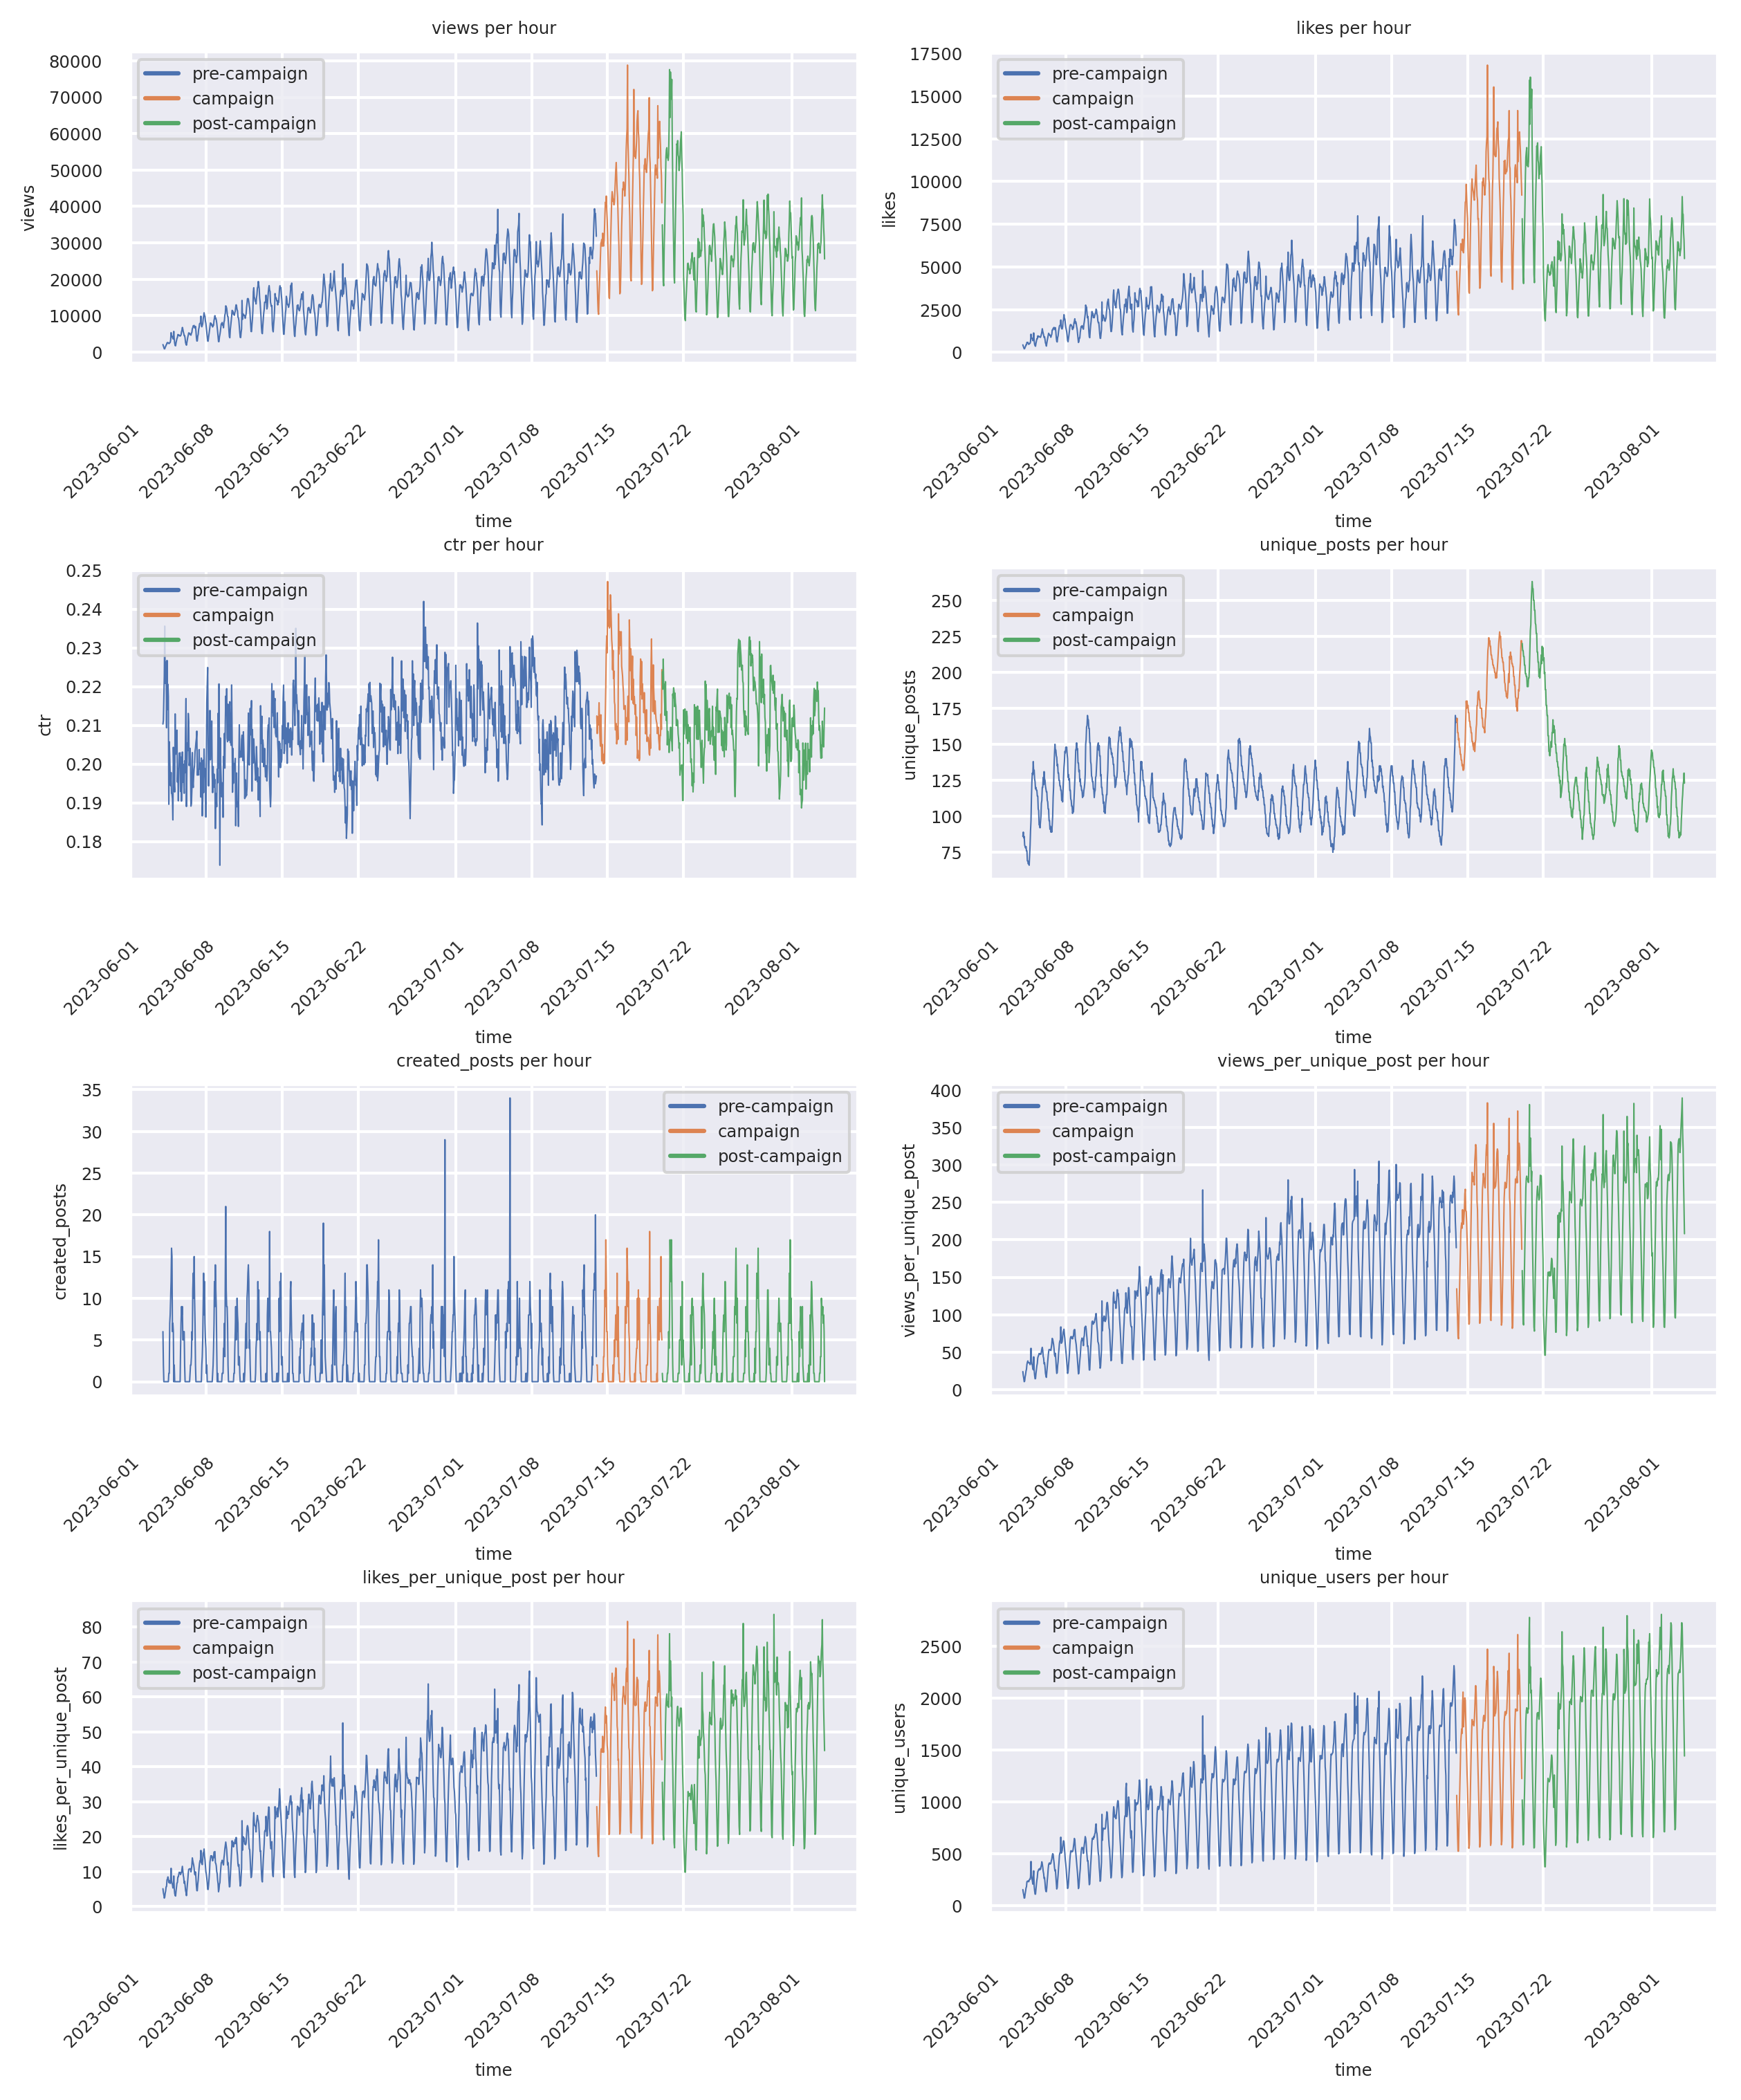

In [31]:
# make a canvas, set sizes
fig, axs = plt.subplots(4, 2, figsize=(50 * SCALE, 60 * SCALE))
for series, ax in zip(list(activity_metrics)[1:-1], axs.reshape(-1)):

    lineplotter(
        data=activity_metrics,
        x='hour',
        y=series,
        ax=ax,
        hue='hour_type',
        title=f'{series} per hour',
        xlabel='time',
        ylabel=f'{series}'
        )

plt.tight_layout()


In [32]:
# now make a query with retentions:
# a dataframe where number of active users is aggregated
# across the day and the starting day of the users

start_date = '2023-07-07'
end_date = '2023-07-24'

query = f'''
WITH retained_users AS (
SELECT *
   FROM
     (SELECT user_id,
             min(toDate(time)) AS start_day
      FROM simulator_20230720.feed_actions
      GROUP BY user_id) t1
   JOIN
     (SELECT DISTINCT user_id,
                      toDate(time) AS day
      FROM simulator_20230720.feed_actions) t2 USING user_id
   WHERE (start_day BETWEEN '{start_date}'::DATE AND '{end_date}'::DATE) AND (day != today())
),

retained_users_by_date_source AS (

SELECT toString(start_day) start_day,
       toString(day) day,
       count(user_id) AS users
FROM retained_users
GROUP BY start_day,
         day
)

SELECT start_day,
day,
users,
MAX(users) OVER (PARTITION BY start_day) AS users_start
FROM retained_users_by_date_source
'''

# import the table to a dataframe; convert number of user to float
# to calculate percentage of users relative to their start day
# at the next steps
users_by_start_day = ph.read_clickhouse(
    query, 
    connection=CONNECTION
).astype(
    dtype={'users_start': 'float'}
) 


In [35]:
users_by_start_day.info()
users_by_start_day.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_day            351 non-null    object 
 1   day                  351 non-null    object 
 2   users                351 non-null    uint64 
 3   users_start          351 non-null    float64
 4   retained_percentage  351 non-null    float64
dtypes: float64(2), object(2), uint64(1)
memory usage: 13.8+ KB


,start_day,day,users,users_start,retained_percentage
0,2023-07-07,2023-07-15,169,996.0,16.967871
1,2023-07-07,2023-07-22,62,996.0,6.224900


In [36]:
# set new columns with percentages  - divide the amount of users by the amount at their starting day
users_by_start_day['retained_percentage'] = users_by_start_day['users'].div(users_by_start_day['users_start']).mul(100)

users_by_start_day.head(2)

,start_day,day,users,users_start,retained_percentage
0,2023-07-07,2023-07-15,169,996.0,16.967871
1,2023-07-07,2023-07-22,62,996.0,6.224900


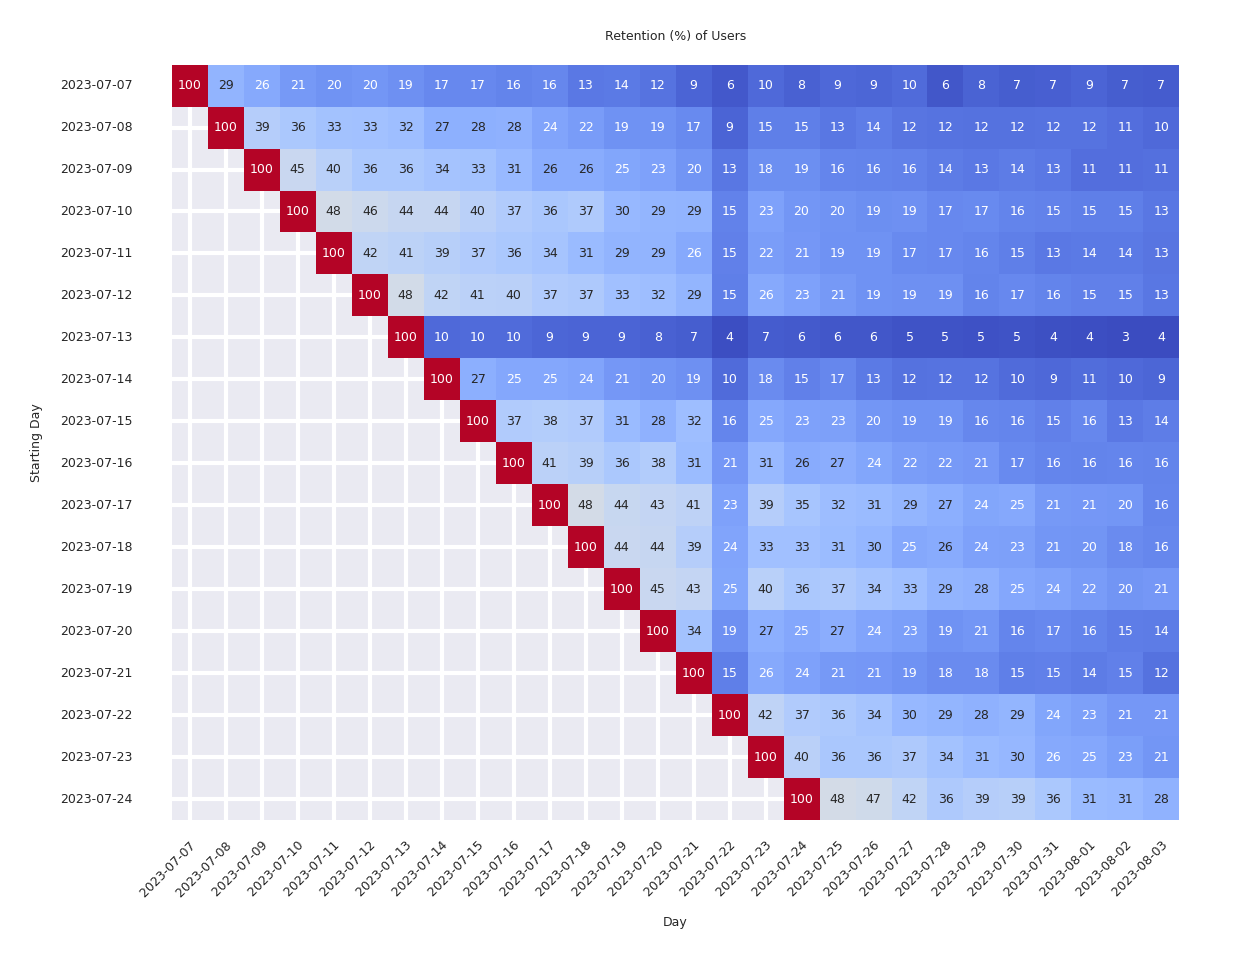

In [37]:
# now, get a heatmap for users retention

# Get a canvas for the plot
fig, ax = plt.subplots(figsize=(26 * SCALE, 20 * SCALE))

# Create a pivot table to reshape the data
pivot_table = users_by_start_day.pivot_table(index='start_day', columns='day', values='retained_percentage')

# Plot the map
heatmapper(
    pivot_table, 
   ax=ax, 
   title='Retention (%) of Users', 
   xlabel='Day',
   ylabel='Starting Day',
   SCALE = SCALE
)


Now to the forecasting: let's initialize the default model without any regressors for each of our metrics

In [38]:
data = activity_metrics[['hour', 'views']].set_index('hour')
data.head()

,views
hour,
2023-06-04 00:00:00,2073
2023-06-04 01:00:00,1661
2023-06-04 02:00:00,1300
2023-06-04 03:00:00,916
2023-06-04 04:00:00,921


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-08-04 14:40:39.083943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-08-04 14:40:39.084153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-08-04 14:40:39.102239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-08-04 14:40:39.102490: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2023-08-04 14:40:40.632130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-04 14:40:40.680534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-04 14:40:40.738852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node monte_carlo_variational_loss/expectation/powerInv

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2023-08-04 14:44:11.124608: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 374800000 exceeds 10% of free system memory.
2023-08-04 14:44:12.666662: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 374800000 exceeds 10% of free system memory.
2023-08-04 14:44:12.782614: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 374800000 exceeds 10% of free system memory.
2023-08-04 14:44:13.141370: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 374800000 exceeds 10% of free system memory.
2023-08-04 14:44:13.368668: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 374800000 exceeds 10% of free system memory.
2023-08-04 14:44:14.756159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/Additi

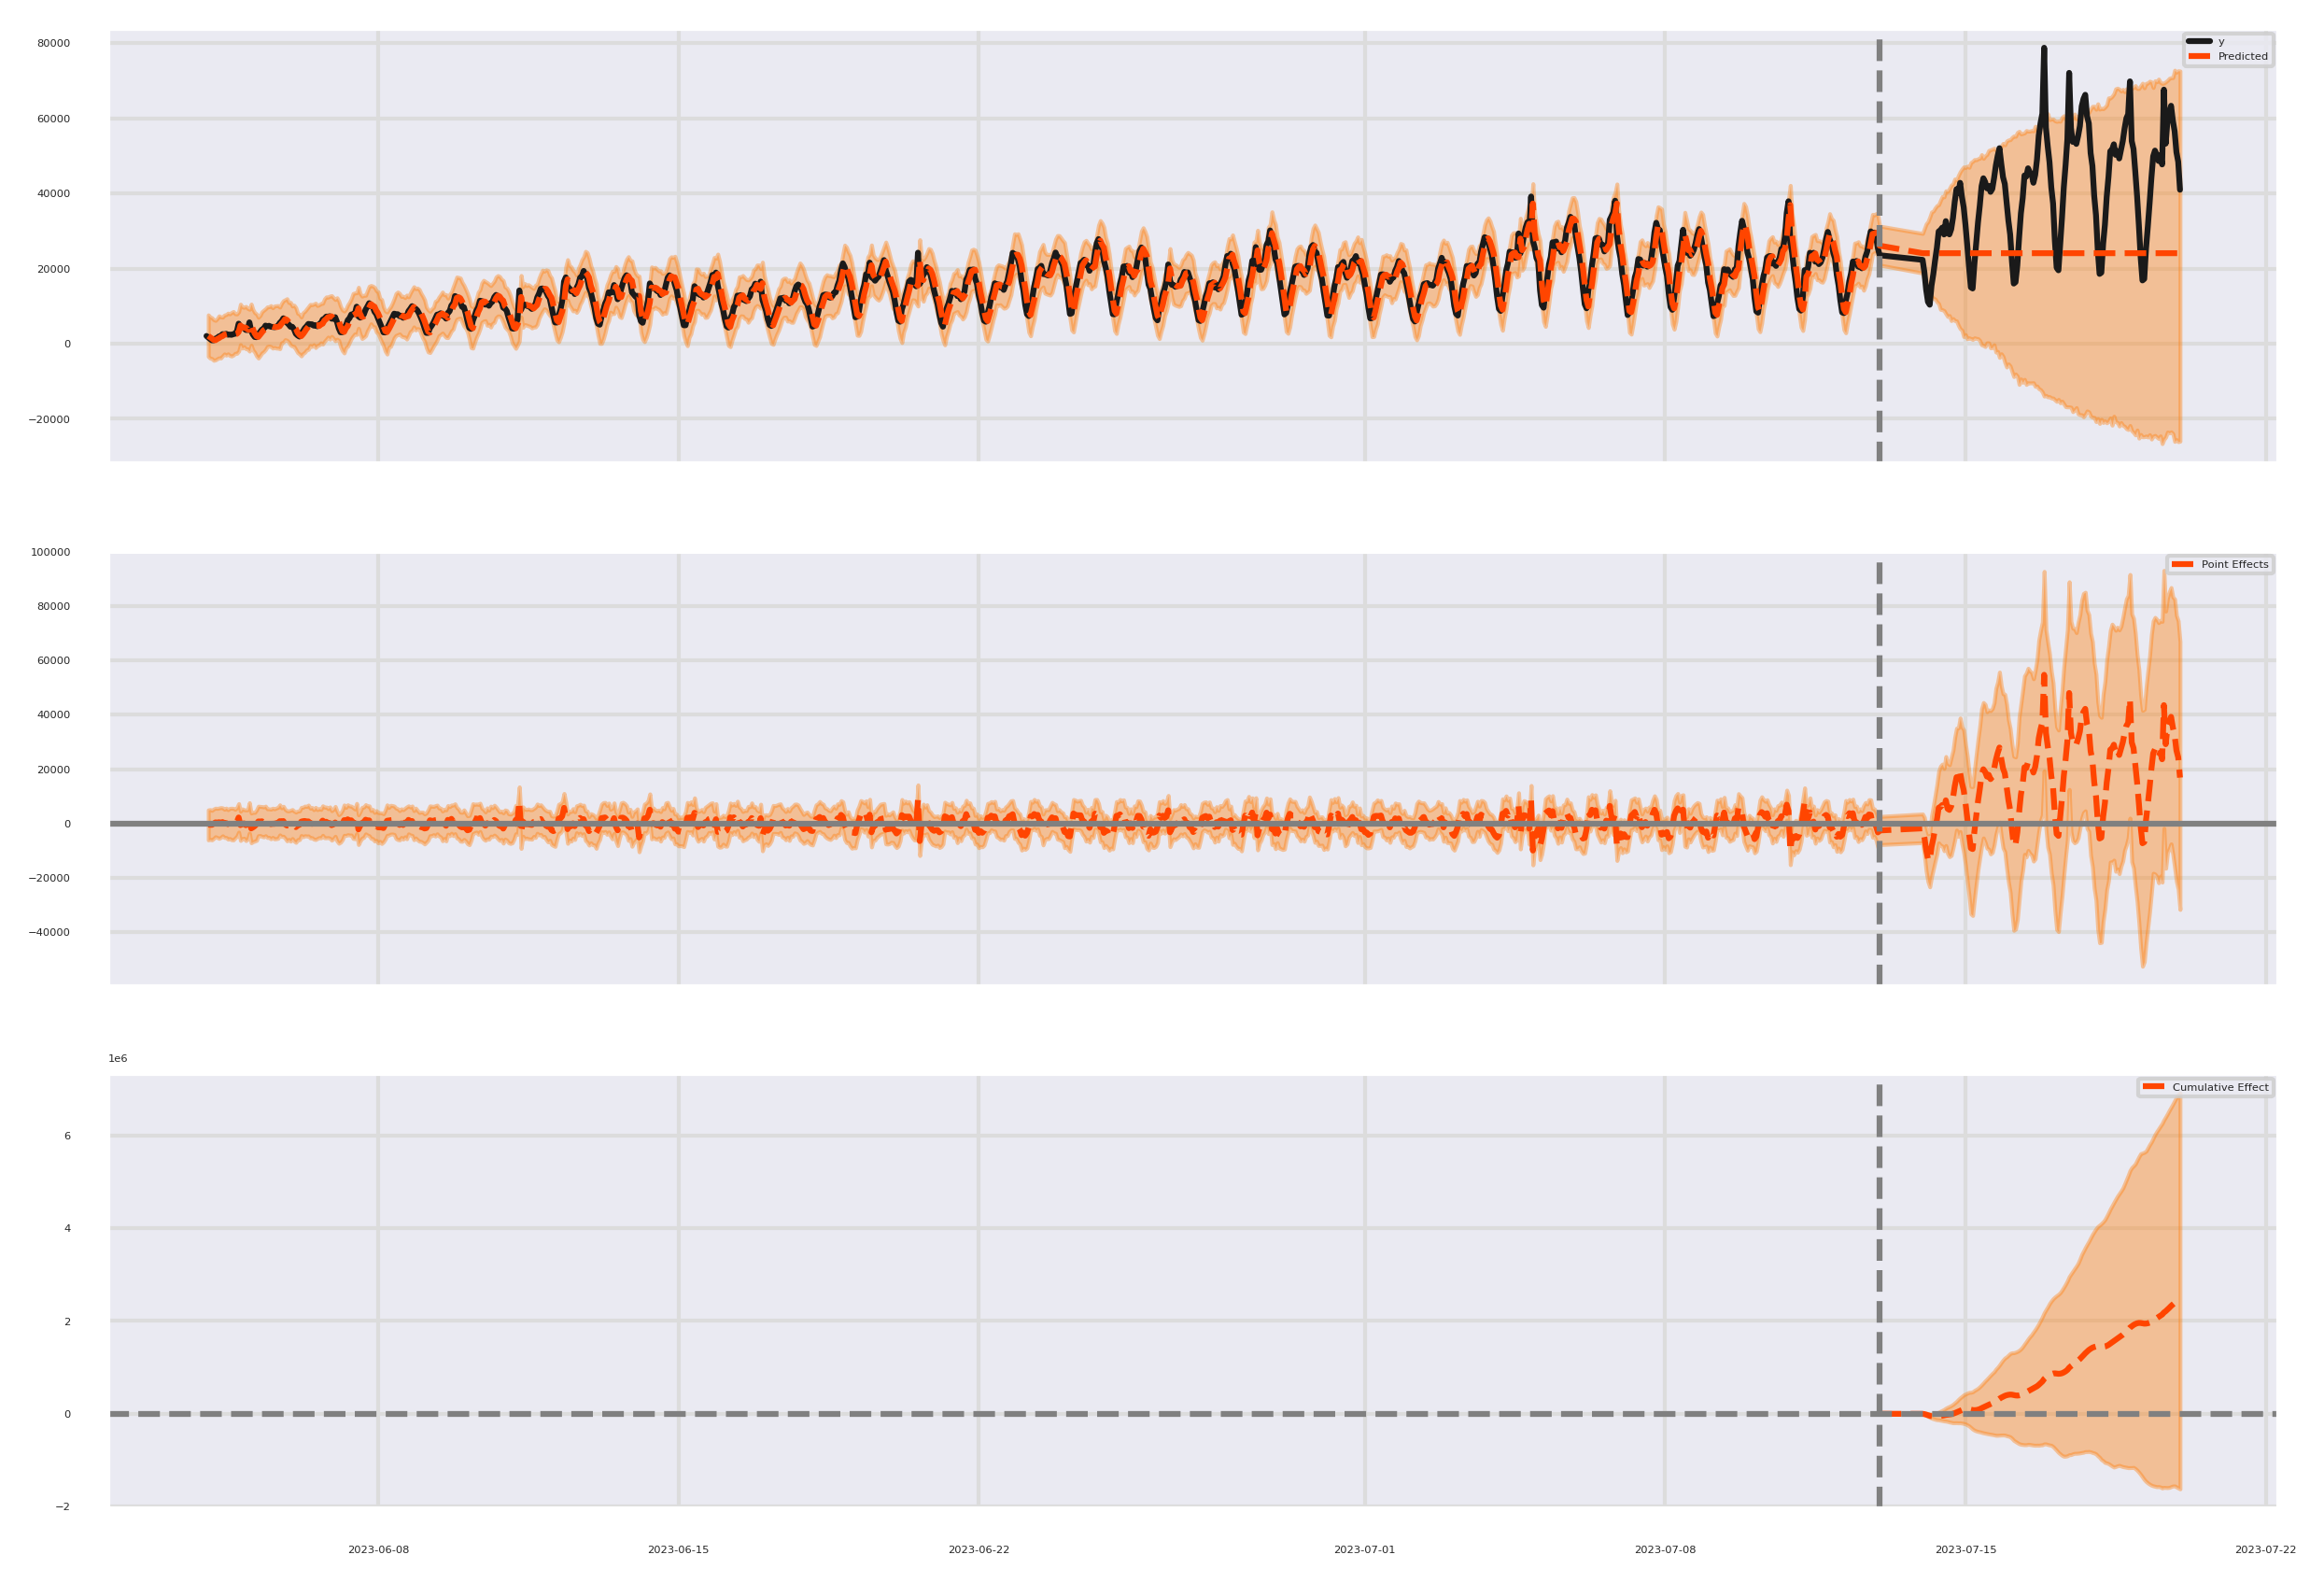

In [39]:
pre_period = [pd.Timestamp('2023-06-04'), pd.Timestamp('2023-07-13')]
post_period = [pd.to_datetime('2023-07-14'), pd.to_datetime('2023-07-20')]
ci = CausalImpact(data, 
                  pre_period, 
                  post_period
                 )
ci.plot()


TypeError: 'Text' object is not callable

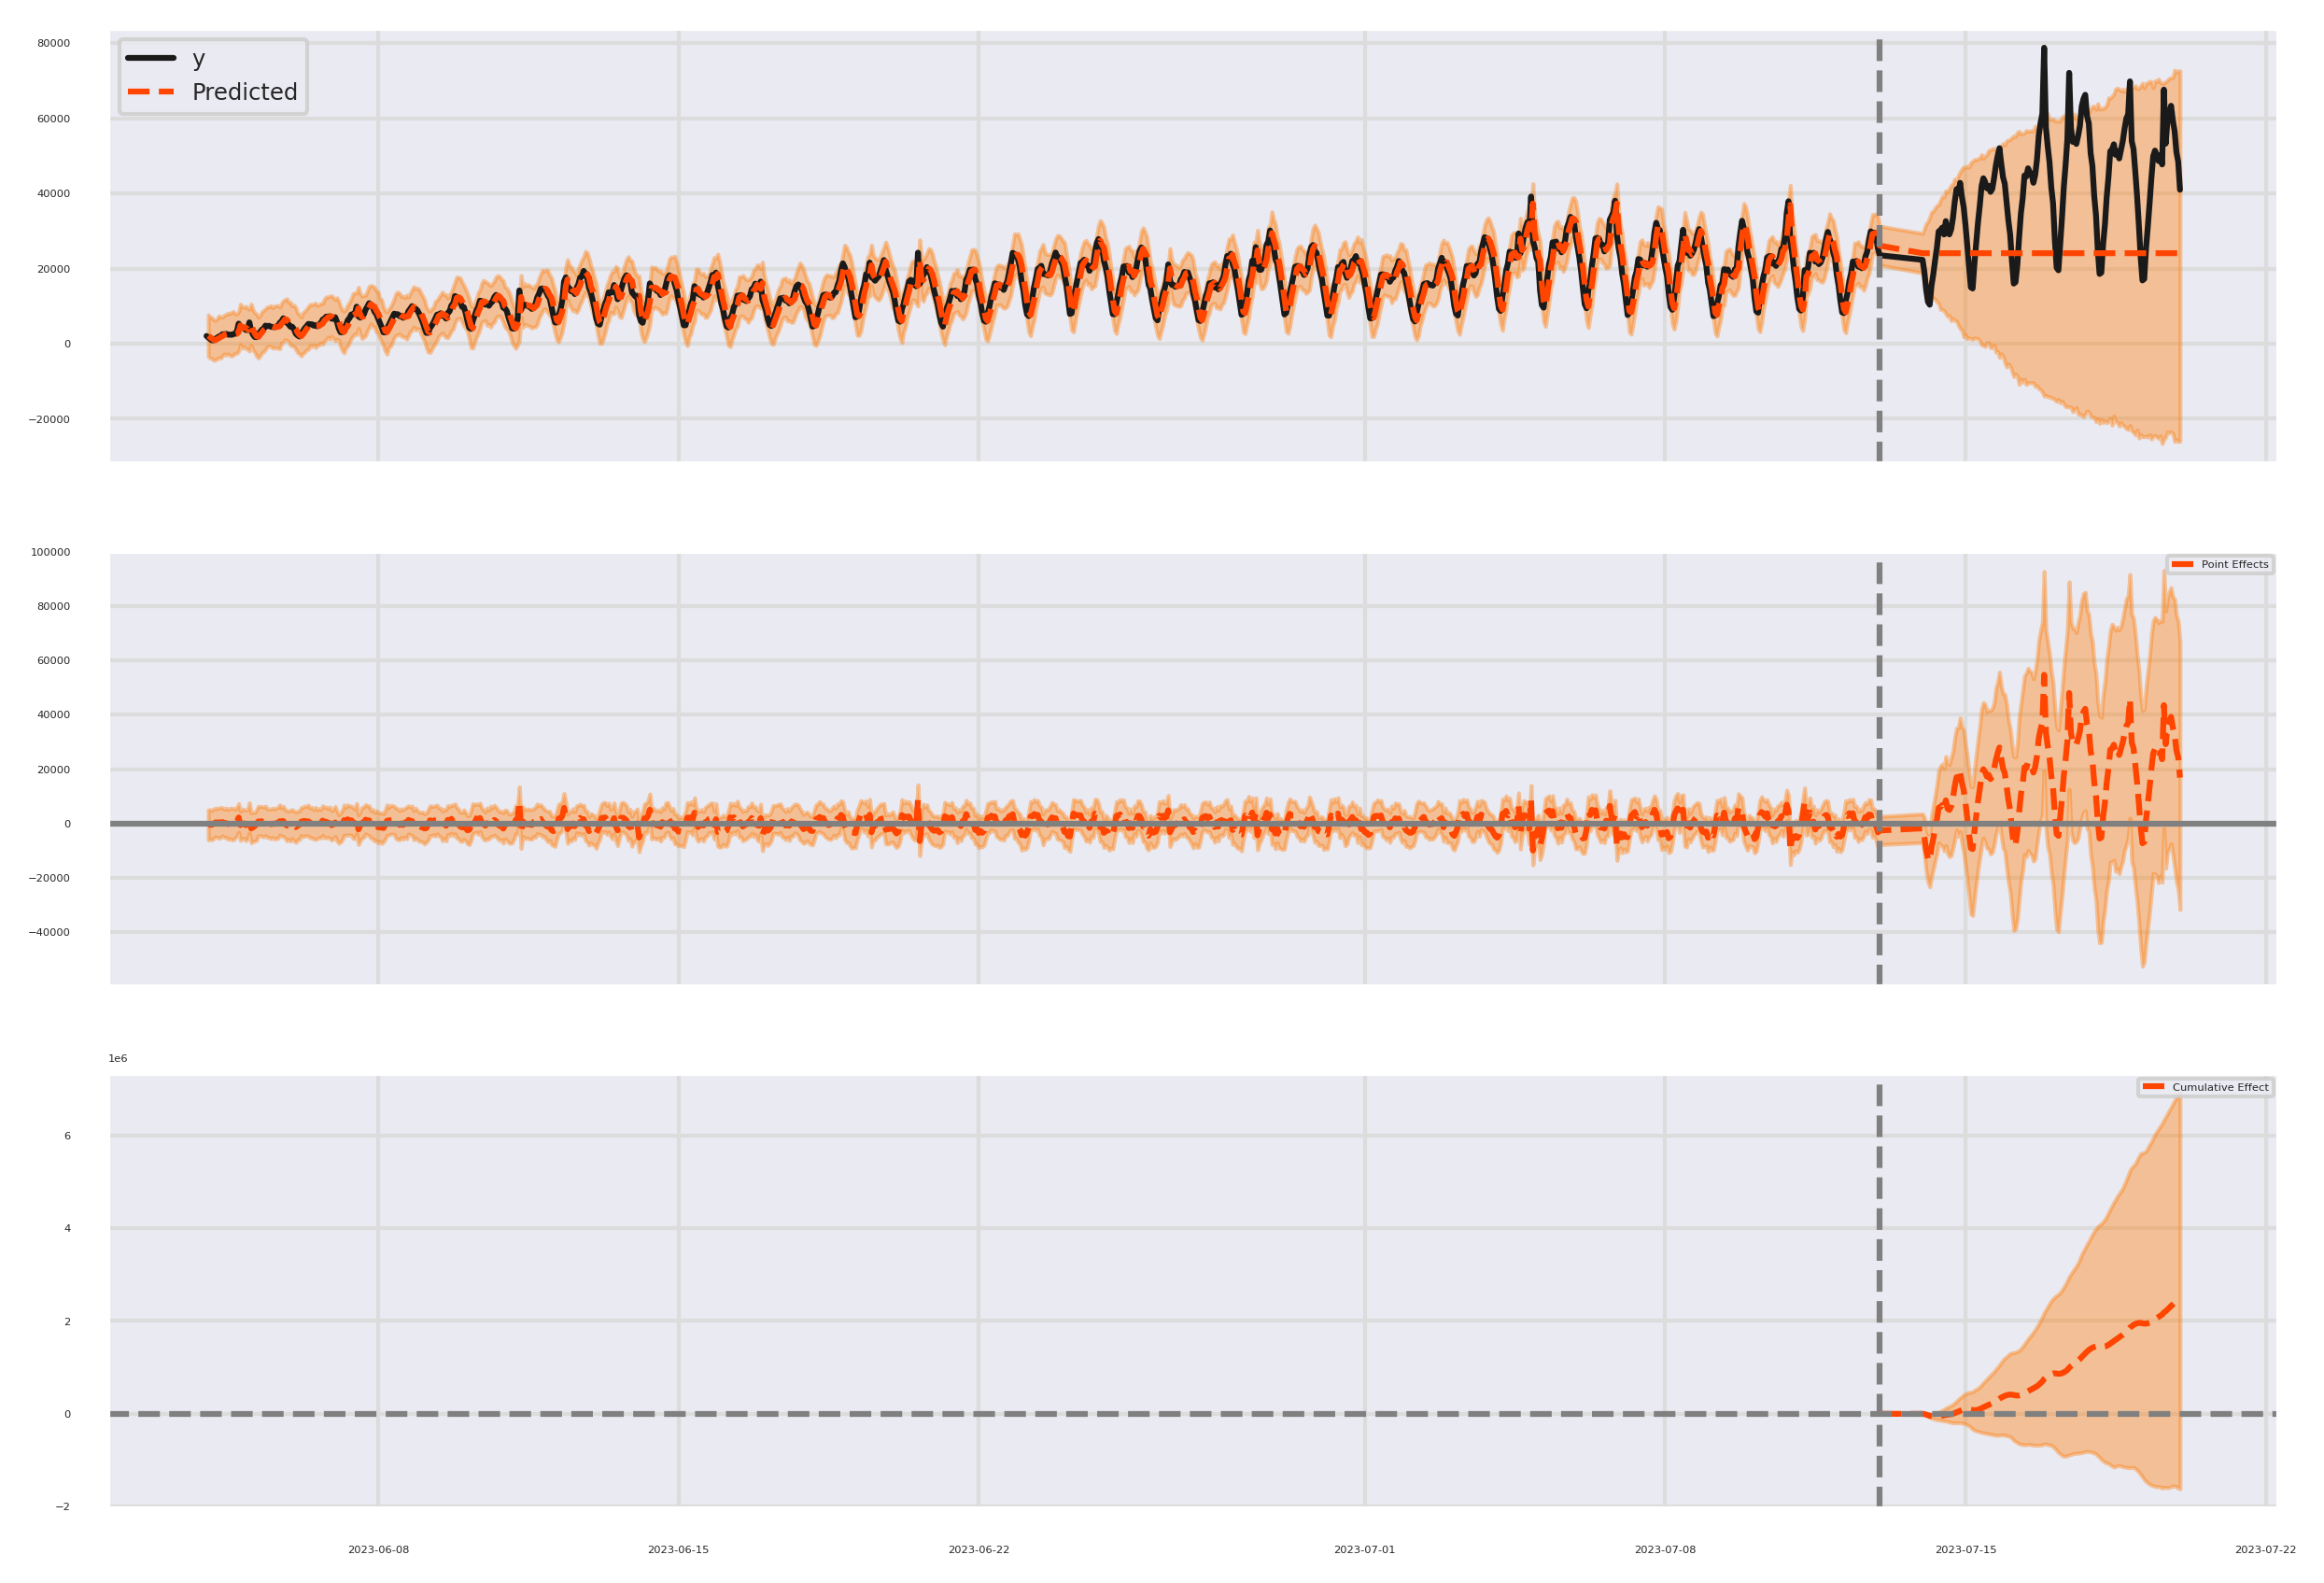

In [48]:
ci.plot(show=False)
fig = plt.gcf()
# List all axes in the figure
all_axes = fig.get_axes()

# Print each axes object
for ax in all_axes:
    ax.legend(fontsize=35 * SCALE)
    ax.title(fontsize=18 * SCALE)
    ax.set_xlabel(fontsize=18 * SCALE)
    ax.set_ylabel(fontsize=18 * SCALE)
    
    # Set the new tick labels
    ax.tick_params(axis='x', rotation=45, labelsize=18 * SCALE)
    ax.tick_params(axis='y', rotation=0, labelsize=18 * SCALE)
# fig.set_legend(fontsize=35 * SCALE)

In [43]:
ax

<Axes: >

<a id="section-3"></a>
### Forecasting: users activity within 1 month with Orbit
---
[Text for Section 3 goes here.]


Задача 2

Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!

    Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
    Постройте модель и провалидируйте её. Хватает ли у нас данных для бэккастинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.
    Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если видите какие-то важные ограничения по выводу – не забудьте их тоже указать.

Бонус: опишите, насколько удобным для использования вам показался Orbit. Если есть опыт использования других прогнозных инструментов (Prophet, Darts и т.д.) – сравните Orbit с ними по тем признакам, которые вам кажутся наиболее важными.

Формат сдачи задания – merge request в GitLab с ноутбуком, где выполнены вычисления (формат .ipynb).